<a href="https://colab.research.google.com/github/sdsc-bw/DataFactory/blob/develop/demos/02_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Feature Engineering
Conceptually, feature engineering is a process that transforms data into features that can better represent business logic, thereby improving the performance of machine learning.

<img src = '../images/fe_pipeline.png'>

As shown in the figure above, it is an important step in data mining. In fact, it is also the most time-consuming <a href = https://whatsthebigdata.com/2016/05/01/data-scientists-spend-most-of-their-time-cleaning-data/> Data Scientists Spend Most of Their Time Cleaning Data </a>.

<img src = '../images/pie.png'>

In this demo we show different transformations and how you can use them in the datafactory.

# How To use in the Datafactory

## Import Package

In [1]:
import sys
if 'google.colab' in sys.modules:
    ! git clone https://github.com/sdsc-bw/DataFactory.git # clone repository for colab
    ! ls

In [2]:
import warnings # igorne irrelevant warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt # library used for visualization
import numpy as np # library for computing efficient calculations
import pandas as pd # library for creating tables
import seaborn as sns # library for plotting statistical data visualization
from abc import ABCMeta, abstractmethod # library to create abstract methods
from sklearn.preprocessing import LabelEncoder # method to encode features
from sklearn.model_selection import train_test_split # method to split data into training and test data and seperate data and targets

## add path to import datafactory 
if 'google.colab' in sys.modules: 
    root = 'DataFactory/'
else:
    root = '../'
sys.path.append(root)

from datafactory.ts.feature_engineering.transforms_binary import * # binary transformations
from datafactory.ts.feature_engineering.transforming import * # transforming methods
from datafactory.ts.plotting.dataset_plotting import plot_density_for_each_column_in_df # density visualization
from datafactory.ts.preprocessing.loading import evaluate # method to evaluate the dataset
from datafactory.ts.preprocessing.cleaning import clean_data # method to clean data

## Load test dataset: diabetes

<a href = 'https://www.openml.org/d/37'> Diabets</a> is an open source data set on OpenCV. It collected the physical conditions of a total of 768 residents living in Phoenix, Arizona, USA. These information include:
- Number of times pregnant
- Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- Diastolic blood pressure (mm Hg)
- Triceps skin fold thickness (mm)
- 2-Hour serum insulin (mu U/ml)
- Body mass index (weight in kg/(height in m)^2)
- Diabetes pedigree function
- Age (years)
- Has diabet


In [4]:
df = pd.read_csv(root + 'data/dataset_37_diabetes.csv')

In [5]:
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


We can see that the prediction target is of the character type, which cannot be processed by most models, so we first convert it to a numeric type with labelencoder

In [6]:
le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Feature engineering
Depending on whether the transformation requires the use of the target value ('class' in the diabetes example), transformations for feature engineering can be distinguished into supervised and unsupervised transformations. And depending on the number of input attributes per conversion unsupervised conversions can again be classified as unary, binary and multivariate conversions.
<img src = '../images/transform.png'>

## Unsupervised Transformation
### Unary Feature transformation

<img width="350" height="360" src = '../images/unary.png'>

In [7]:
class UnaryOpt(metaclass=ABCMeta):
    @abstractmethod
    def fit(self, value: pd.Series) -> pd.Series:
        pass

All unary transform are wrapped as a subclass of 'UnaryOpt', which has one fix function 'fit'. Following is a brief introduction and demonstration of the unary conversion
* abs: |x|
* add: x + e
* negative: -x
* log: log(x)
* exp: e^x
* reciprocol: 1/x
* square: x*x
* squrt: 
* cos: cos(x)
* sin: sin(x)
* degree: Convert angles from radians to degrees
* radians: Convert angles from degrees to radians
* sigmoid: 1 / (1 + exp(-x))
* tanh: sinh(x)/cosh(x)
* relu: x * (x > 0)
* binning: clustering for a single feature
* ktermfreq: value counts

To simplify the programming, sdsc researchers developed the DataFactory class (the specifics of this class will be described in other notebooks), which can finish all the unary transformation in one function.
- apply_unary_transformations_to_series(self, value: pd.Series) -> pd.DataFrame
    - It takes a series (feature) as input and output a dataframe after the transformation

In [8]:
tmp_df = apply_unary_transforms_to_series(df['preg'])
tmp_df

2022-02-03 15:51:26,460 - Start to apply unary transformtions to series: preg...
2022-02-03 15:51:26,462 - Applying transformation: abs
2022-02-03 15:51:26,463 - Applying transformation: cos
2022-02-03 15:51:26,463 - Applying transformation: degree
2022-02-03 15:51:26,465 - Applying transformation: exp
2022-02-03 15:51:26,466 - Applying transformation: ln
2022-02-03 15:51:26,467 - Applying transformation: negative
2022-02-03 15:51:26,468 - Applying transformation: radian
2022-02-03 15:51:26,469 - Applying transformation: reciprocal
2022-02-03 15:51:26,470 - Applying transformation: sin
2022-02-03 15:51:26,472 - Applying transformation: sigmoid
2022-02-03 15:51:26,474 - Applying transformation: square
2022-02-03 15:51:26,475 - Applying transformation: tanh
2022-02-03 15:51:26,477 - Applying transformation: relu
2022-02-03 15:51:26,478 - Applying transformation: sqrt
2022-02-03 15:51:26,478 - Applying transformation: binning
2022-02-03 15:51:26,517 - Applying transformation: ktermFreq
20

,abs(preg),cos(preg),degree(preg),exp(preg),log(preg),-(preg),radian(preg),reciprocal(preg),sin(preg),sigmoid(preg),square(preg),tanh(preg),relu(preg),sqrt(preg),binning(preg),kterm(preg)
0,6,0.960170,343.774677,403.428793,1.791759,-6,0.104720,0.166667,-0.279415,0.997527,36,0.999988,6,2.449490,2,0.065104
1,1,0.540302,57.295780,2.718282,0.000000,-1,0.017453,1.000000,0.841471,0.731059,1,0.761594,1,1.000000,6,0.175781
2,8,-0.145500,458.366236,2980.957987,2.079442,-8,0.139626,0.125000,0.989358,0.999665,64,1.000000,8,2.828427,1,0.049479
3,1,0.540302,57.295780,2.718282,0.000000,-1,0.017453,1.000000,0.841471,0.731059,1,0.761594,1,1.000000,6,0.175781
4,0,1.000000,0.000000,1.000000,-inf,0,0.000000,0.000000,0.000000,0.500000,0,0.000000,0,0.000000,4,0.144531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,-0.839072,572.957795,22026.465795,2.302585,-10,0.174533,0.100000,-0.544021,0.999955,100,1.000000,10,3.162278,5,0.031250
764,2,-0.416147,114.591559,7.389056,0.693147,-2,0.034907,0.500000,0.909297,0.880797,4,0.964028,2,1.414214,0,0.134115
765,5,0.283662,286.478898,148.413159,1.609438,-5,0.087266,0.200000,-0.958924,0.993307,25,0.999909,5,2.236068,2,0.074219
766,1,0.540302,57.295780,2.718282,0.000000,-1,0.017453,1.000000,0.841471,0.731059,1,0.761594,1,1.000000,6,0.175781


One noteworthy thing is that feature transformation can lead to the generation of implausible values, such as the fifth value of log(preg) in the table above. Since the original value is 0, the corresponding log value is negative infinity.

The next few plots show the density distribution of the attributes before and after the conversion, and we can see that their density distribution functions show a big difference, and this is the main reason for our conversion

<AxesSubplot:xlabel='preg', ylabel='Density'>

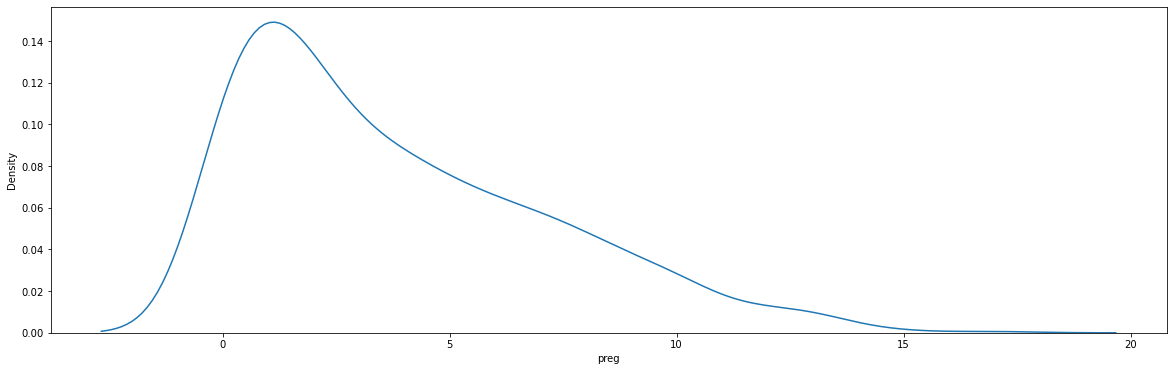

In [9]:
plt.figure(figsize=(20,6))
sns.kdeplot(df['preg'])

2022-02-03 15:51:26,832 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-02-03 15:51:26,835 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-02-03 15:51:26,868 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-02-03 15:51:26,871 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-02-03 15:51:26,905 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-02-03 15:51:26,908 - No artists with labels found to put in legend.  Note that a

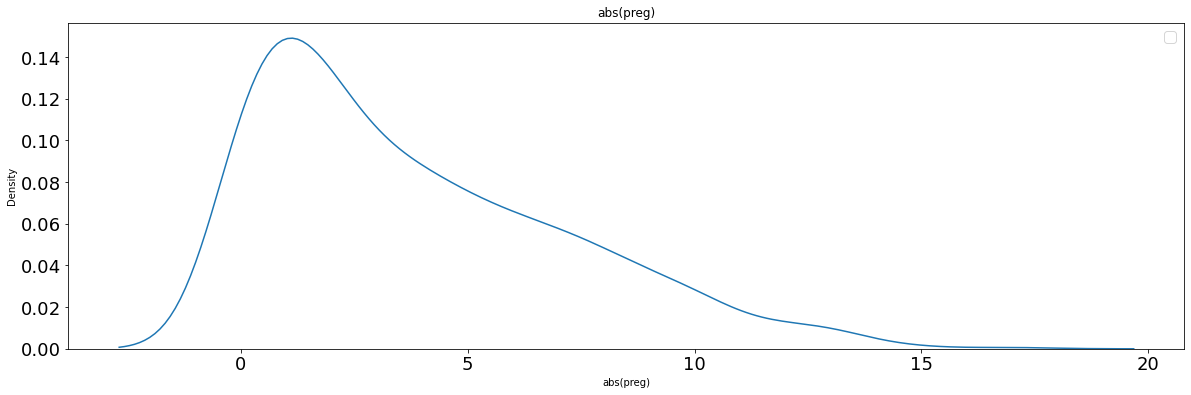

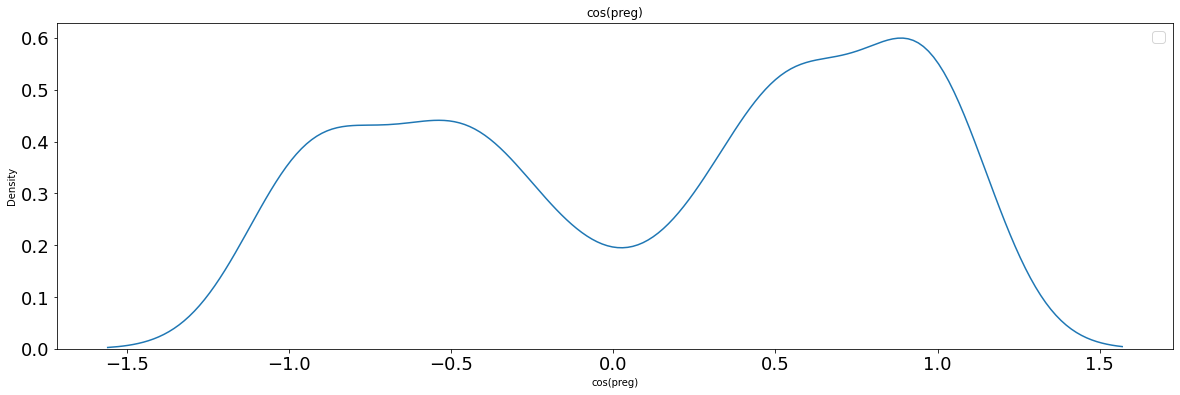

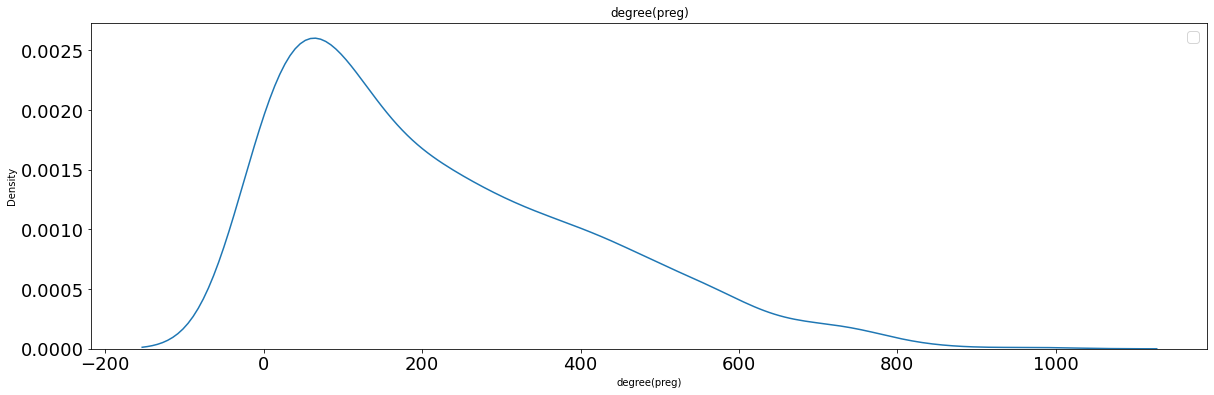

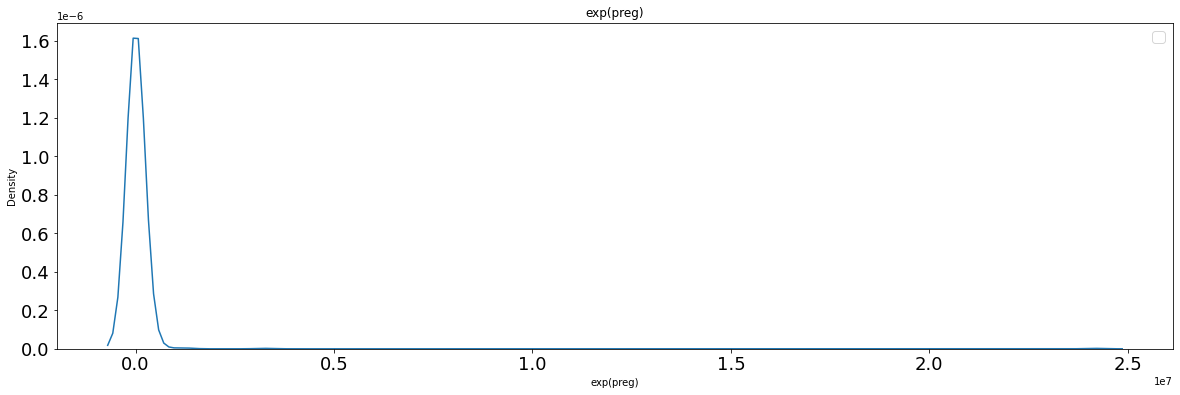

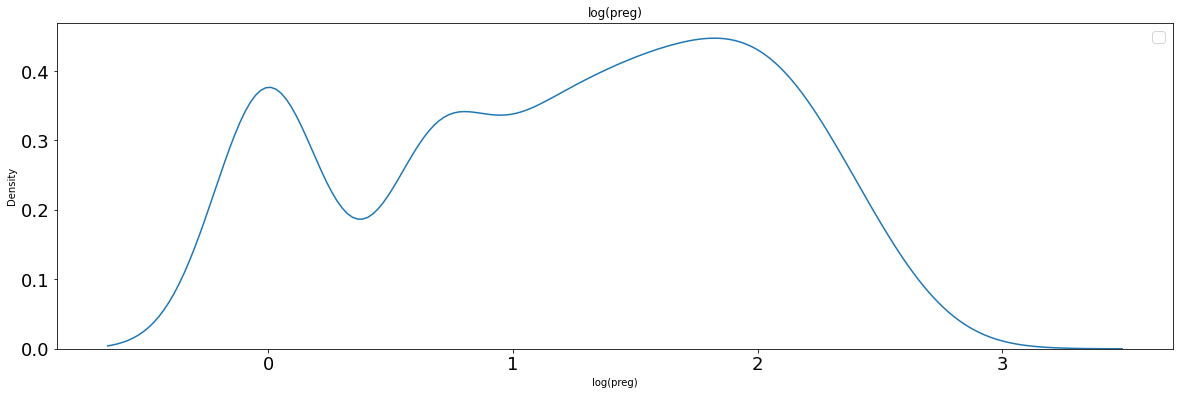

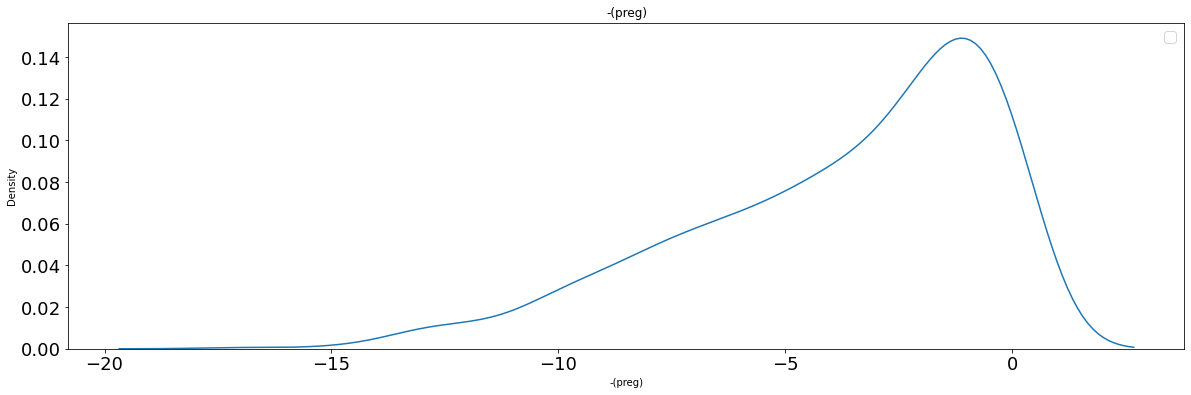

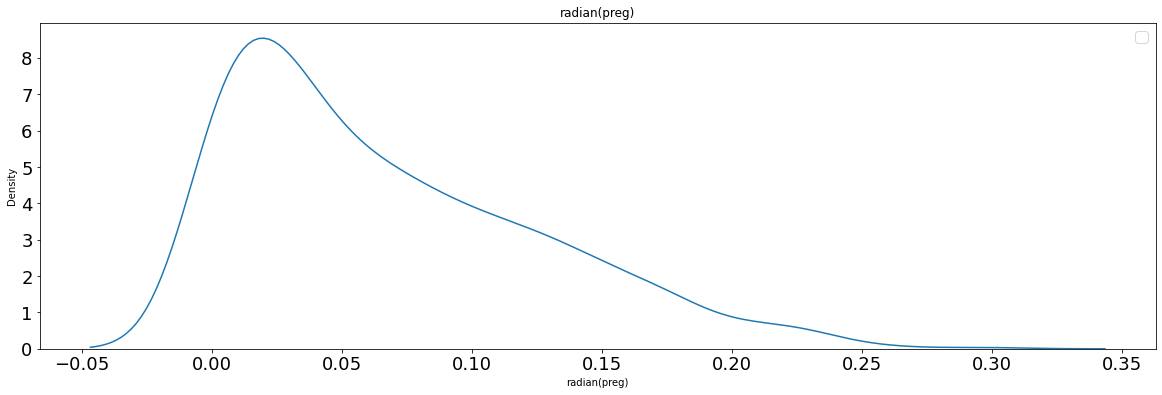

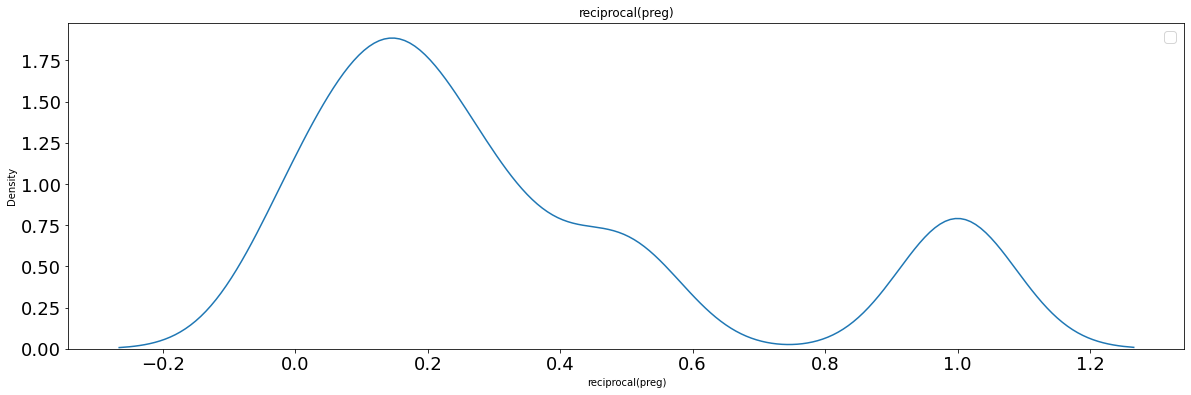

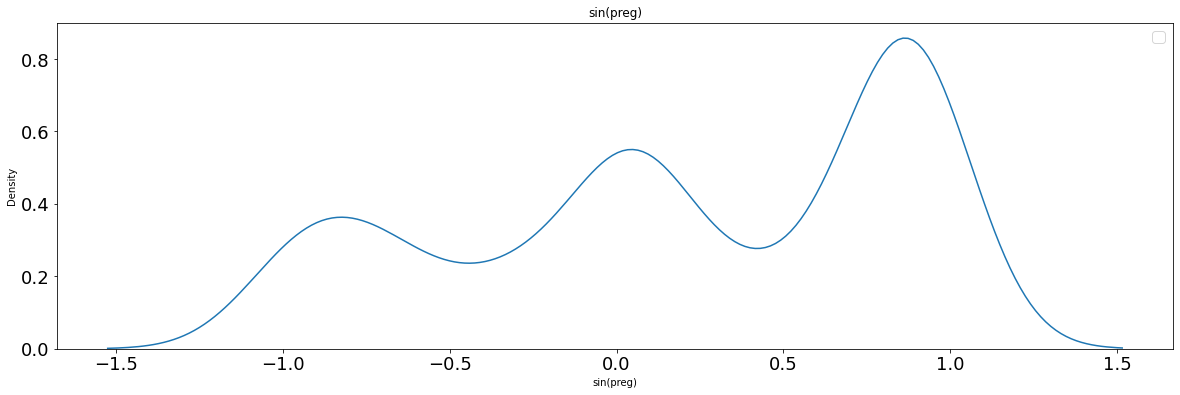

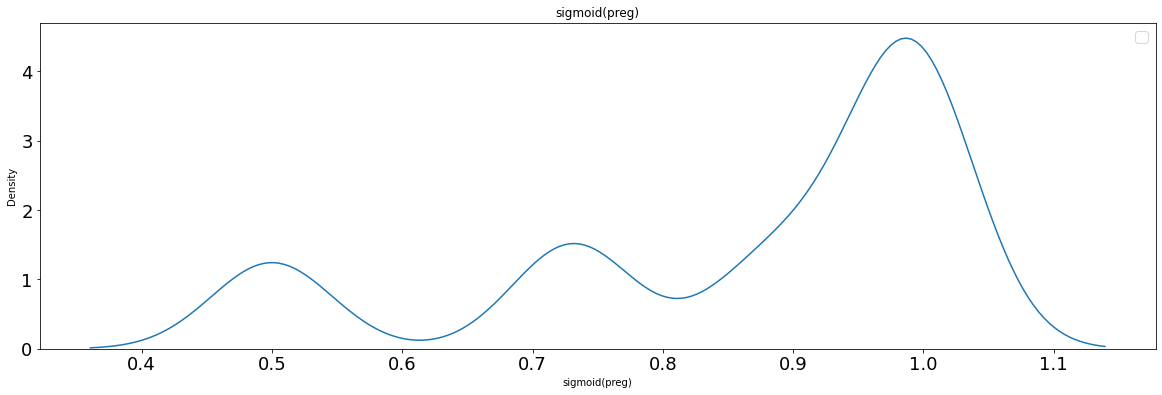

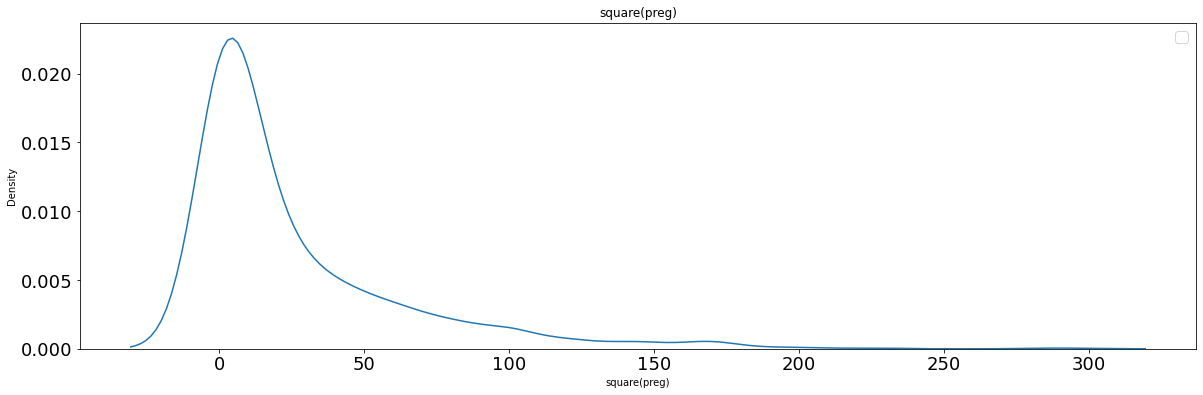

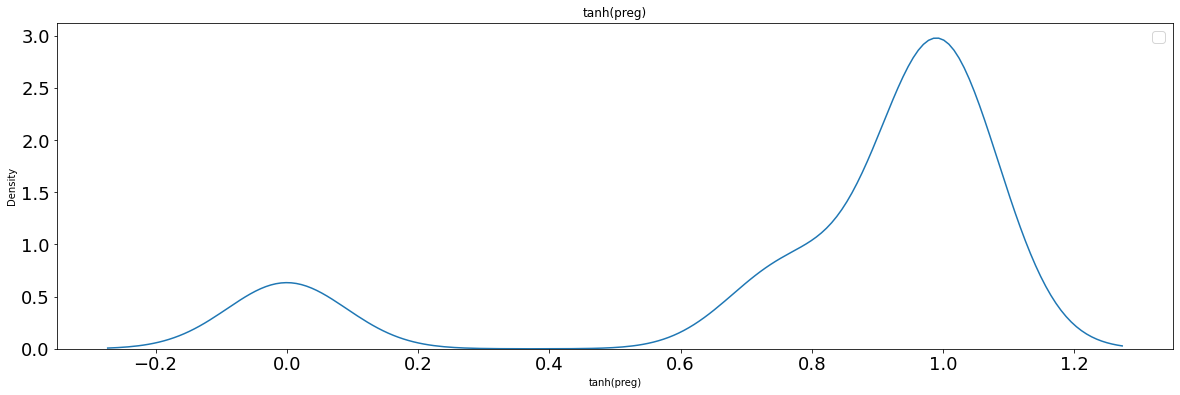

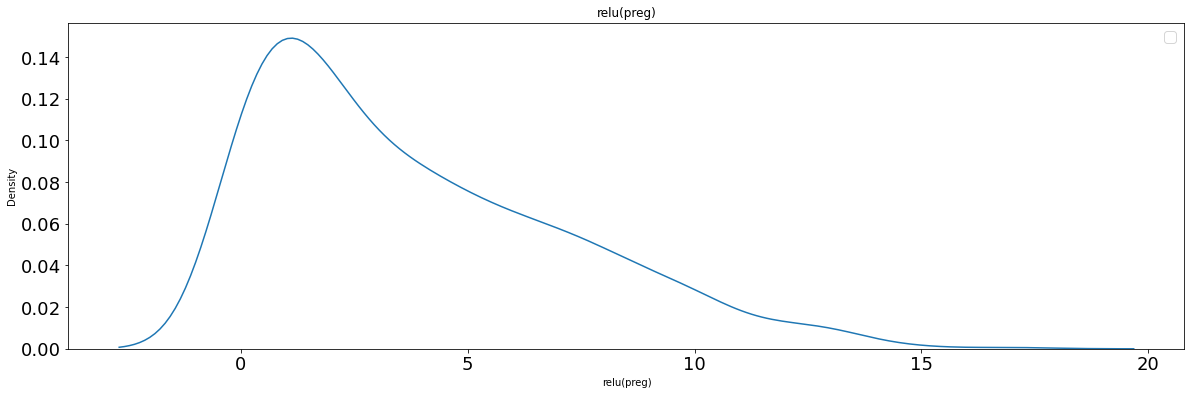

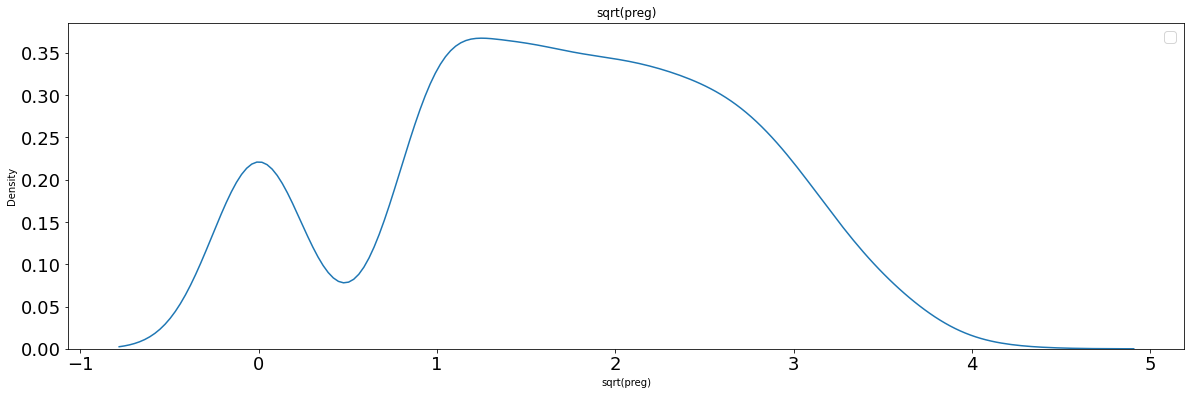

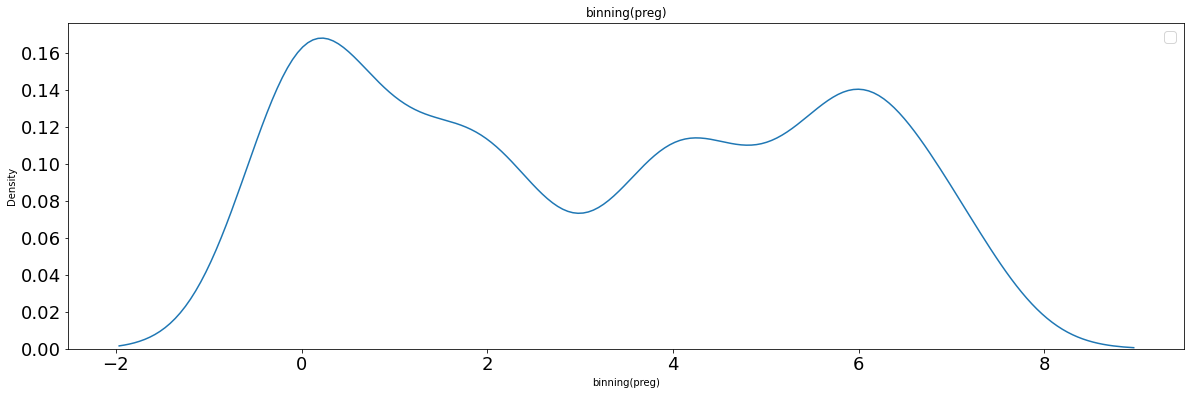

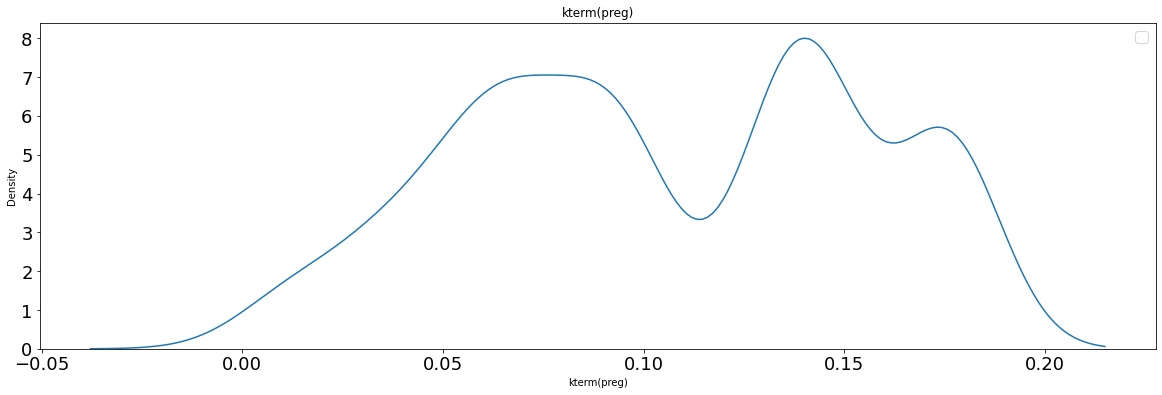

In [10]:
plot_density_for_each_column_in_df(tmp_df)

### Binary feature transformation

<img width="350" height="360" src = '../images/binary.png'>

In [11]:
class BinaryOpt(metaclass=ABCMeta):
    @abstractmethod
    def fit(self, value1: pd.Series, value2: pd.Series) -> pd.Series:
        pass

All unary transform are wrapped as a subclass of 'BinaryOpt', which has one fix function 'fit'. It takes two series as input and output the series after transformation. There are only four binary transformation defiend in DataFactory class.

In [12]:
operators = {'div': Div(), 'minus': Minus(), 'add': Add(), 'product': Product()}

In [13]:
tmp_df = apply_binary_transforms_to_series(df['preg'], df['plas'])
tmp_df

2022-02-03 15:51:29,024 - Start to apply binary transformtions to series preg and series plas...
2022-02-03 15:51:29,025 - Applying transformation: div
2022-02-03 15:51:29,026 - Applying transformation: minus
2022-02-03 15:51:29,027 - Applying transformation: add
2022-02-03 15:51:29,027 - Applying transformation: product
2022-02-03 15:51:29,028 - ...End with binary transformation


,preg/plas,preg-plas,preg+plas,preg*plas
0,0.040541,-142,154,888
1,0.011765,-84,86,85
2,0.043716,-175,191,1464
3,0.011236,-88,90,89
4,0.000000,-137,137,0
...,...,...,...,...
763,0.099010,-91,111,1010
764,0.016393,-120,124,244
765,0.041322,-116,126,605
766,0.007937,-125,127,126


### Multiple feature transformation

<img width="650" height="660" src = '../images/multiple.png'>

All unary transform are wrapped as a subclass of 'MultiOpt', which also has one fix function 'fit'. The multivariate transformation takes several different features as input (generally the whole dataset) and its output generally contains one or more different features in form of DataFrame. The transformation functions can be broadly classified into clustering, regularization, downscaling and time series attribute extraction. At present, SDSC researchers do not implement all possible transformation methods, for example, for the clustering method category only Kmeans is implemented, while other common clusters are not implemented.

- Clustering: 
    - clustering the data set with Kmeans and use the result as new feature.
    - Because most, datasets contain dozens of features, and kmeans does not perform well on high-dimensional data, SDSC staff incorporates a sliding window mechanism in clustering, where values are clustered only for features in the same window.
- Normalization:
    - minmax 
    - zscore
- Dimension_reduction:
    - isomap
- Time_series feature extraction: each item in the dataset is treated as a time series
    - Diff: diff between the columns
    - WinAgg
        - apply sliding window to it and aggregate
        - agg func include: max, .25, .50, .75, max, std
- Other:
    - LeakyInfo
    - KernelApproxRBF: use rbf to approximate kernel


In [14]:
class MultiOpt(metaclass=ABCMeta):
    @abstractmethod
    def fit(self, df: pd.DataFrame):
        pass

In [15]:
tmp_df = apply_multiple_transforms_to_dataframe(df.iloc[:, :-1])
tmp_df

2022-02-03 15:51:29,072 - Start to apply multi transformtions to dataframe...
2022-02-03 15:51:29,073 - Applying transformation: clustering
2022-02-03 15:51:29,201 - Applying transformation: diff
2022-02-03 15:51:29,203 - Applying transformation: mmnorm
2022-02-03 15:51:29,208 - Applying transformation: Winagg
2022-02-03 15:51:29,582 - Applying transformation: zscore
2022-02-03 15:51:29,586 - Applying transformation: nominalExpansion
2022-02-03 15:51:29,592 - Applying transformation: isomap
2022-02-03 15:51:29,849 - Applying transformation: leakyInfo
2022-02-03 15:51:30,078 - Applying transformation: kernelapproxrbf
2022-02-03 15:51:30,081 - ...End with multi transformation


,Clustering_pppsimpa,Clustering_pppsimpa,diff_preg,diff_plas,diff_pres,diff_skin,diff_insu,diff_mass,diff_pedi,diff_age,...,pedi_leaky,age_leaky,preg_rbfFeature,plas_rbfFeature,pres_rbfFeature,skin_rbfFeature,insu_rbfFeature,mass_rbfFeature,pedi_rbfFeature,age_rbfFeature
0,0,0,NaN,142,-76,-37,-35,33.6,-32.973,49.373,...,-0.219334,-15.499142,-0.320824,-0.452838,-0.120935,-0.109633,0.247241,0.399702,0.499981,0.263012
1,4,0,NaN,84,-19,-37,-29,26.6,-26.249,30.649,...,-0.007732,-3.312309,0.373550,-0.251601,0.309338,-0.472505,-0.056166,0.067086,-0.029754,-0.277813
2,0,5,NaN,175,-119,-64,0,23.3,-22.628,31.328,...,-0.306620,5.559581,-0.473251,0.454305,-0.344738,0.476418,0.491823,-0.499981,0.465239,0.497893
3,2,3,NaN,88,-23,-43,71,-65.9,-27.933,20.833,...,0.263541,3.350916,0.265112,0.448459,-0.351757,-0.380190,-0.102177,-0.370948,0.491525,-0.408163
4,5,6,NaN,137,-97,-5,133,-124.9,-40.812,30.712,...,-1.706770,-4.809648,-0.472409,-0.186061,0.482654,0.469311,0.441693,-0.157384,-0.370891,0.276063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,5,6,NaN,91,-25,-28,132,-147.1,-32.729,62.829,...,0.410079,-34.770189,0.241974,-0.198488,-0.495610,0.079252,-0.468580,-0.454106,0.486031,0.484672
764,4,0,NaN,120,-52,-43,-27,36.8,-36.460,26.660,...,0.015163,4.767827,-0.400256,-0.404139,0.380641,-0.267871,0.381568,0.260715,-0.294834,0.350229
765,2,4,NaN,116,-49,-49,89,-85.8,-25.955,29.755,...,0.158934,-2.113720,-0.493713,-0.265526,0.018965,0.499977,-0.299163,0.492733,-0.029348,-0.475447
766,4,5,NaN,125,-66,-60,0,30.1,-29.751,46.651,...,0.003426,-15.221553,-0.300519,-0.471418,-0.485089,0.486363,-0.433627,0.486451,-0.433881,-0.427000


## Supervised Transformation

This category is more complex and it mainly uses some existing models, such as decision trees, k-nearest neighbors, etc., to assist in generating new features. Depending on the type of dataset, it can be broadly classified into two main types: classification and regression.

Another special feature of this classification is that since the target value of the test set is unknown, there is no way to generate new features purely by relying on the test set. The composition of the features in the test set depends on the model built in the training set.

Taking DecisionTreeClassifier for example, following three information can be extracted:
- regard each node in the last layer of the tree as a cluster, extract the clustering information
- use the prediction of the model
- compute the distance between the predictt and ground_truth

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1])
tmp_df, tmp_df2 = apply_supervised_transforms_to_dataframe(X_train, X_test, y_train, y_test, 'C')
tmp_df

2022-02-03 15:51:30,123 - Start to apply supervised transformtions to dataframe...
2022-02-03 15:51:30,123 - Applying transformation: decisionTreeClassifierTransform
2022-02-03 15:51:30,189 - Applying transformation: mlpClassifierTransform
2022-02-03 15:51:31,639 - Applying transformation: nearestNeighborsClassifierTransform
2022-02-03 15:51:32,180 - Applying transformation: svcTransform
2022-02-03 15:51:32,213 - Applying transformation: gauDotClassifierTransform
2022-02-03 15:51:38,667 - Applying transformation: gauExpClassifierTransform
2022-02-03 15:51:48,214 - Applying transformation: gauRBFClassifierTransform
2022-02-03 15:51:56,590 - Applying transformation: randomForestClassifierTransform
2022-02-03 15:51:56,748 - Applying transformation: xgbClassifierTransform
2022-02-03 15:51:56,865 - ...End with supervised transformation


[15:51:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,dt_cla_cluster,dt_cla_pred,mlp_pred_0_8,mlp_pred_1_8,mlp_pred_2_8,mlp_pred_3_8,mlp_pred_4_8,mlp_pred_5_8,mlp_pred_6_8,mlp_pred_7_8,...,pedi,age,preg,plas,pres,skin,insu,mass,pedi,age
63,4,0,10.745543,0.000000,8.010228,0.0,7.921979,0.0,0.000000,0.0,...,0.699,24,2,141,58,34,128,25.4,0.699,24
671,0,0,0.000000,6.429614,0.000000,0.0,3.584743,0.0,5.080876,0.0,...,0.551,21,1,99,58,10,0,25.4,0.551,21
300,7,1,0.574686,0.861344,0.000000,0.0,0.814945,0.0,2.268631,0.0,...,0.839,30,0,167,0,0,0,32.3,0.839,30
440,7,1,0.870347,11.394735,0.000000,0.0,8.828440,0.0,8.755584,0.0,...,0.435,41,0,189,104,25,0,34.3,0.435,41
43,7,1,16.796120,0.000000,20.098568,0.0,6.527439,0.0,4.617822,0.0,...,0.721,54,9,171,110,24,240,45.4,0.721,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,3,0,0.000000,17.244394,1.477684,0.0,0.000000,0.0,12.651601,0.0,...,0.237,58,8,110,76,0,0,27.8,0.237,58
159,7,1,12.502929,0.000000,7.890799,0.0,4.152434,0.0,0.487207,0.0,...,0.817,47,17,163,72,41,114,40.9,0.817,47
36,5,0,0.000000,9.575857,0.000000,0.0,0.168047,0.0,9.222697,0.0,...,0.420,35,11,138,76,0,0,33.2,0.420,35
695,5,1,33.436077,0.000000,51.821472,0.0,3.431159,0.0,6.502300,0.0,...,0.128,43,7,142,90,24,480,30.4,0.128,43


In [17]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1])
tmp_df, tmp_df2 = apply_supervised_transforms_to_dataframe(X_train, X_test, y_train, y_test, 'R')
tmp_df

2022-02-03 15:51:56,930 - Start to apply supervised transformtions to dataframe...
2022-02-03 15:51:56,931 - Applying transformation: decisionTreeRegressorTransform
2022-02-03 15:51:57,007 - Applying transformation: linearRegressorTransform
2022-02-03 15:51:57,017 - Applying transformation: mlpRegressorTransform
2022-02-03 15:51:58,550 - Applying transformation: nearestNeighborsRegressorTransform
2022-02-03 15:51:58,626 - Applying transformation: svrTransform
2022-02-03 15:51:58,676 - Applying transformation: gauDotWhiteRegressorTransform
2022-02-03 15:51:59,962 - Applying transformation: gauExpRegressorTransform
2022-02-03 15:52:01,715 - Applying transformation: gauRBFRegressorTransform
2022-02-03 15:52:03,232 - Applying transformation: randomForestRegressorTransform
2022-02-03 15:52:03,750 - Applying transformation: xgbRegressorTransform
2022-02-03 15:52:03,998 - ...End with supervised transformation


,preg,plas,pres,skin,insu,mass,pedi,age,linear_pred,linear_pred_diff,...,insu,mass,pedi,age,gaurbf_reg_pred,gaurbf_reg_pred_diff,rfr_pred,rfr_pred_diff,xgb_reg_pred515,xgb_reg_pred_diff515
323,13.0,152.0,90.0,33.0,29.0,26.8,0.731,43.0,0.699294,3.417516e-17,...,29.0,26.8,0.731,43.0,1.000000e+00,1.012192e-10,0.86,0.0798,0.998095,0.001982
635,13.0,104.0,72.0,0.0,0.0,31.2,0.465,38.0,0.414791,7.391881e-16,...,0.0,31.2,0.465,38.0,1.000000e+00,2.390263e-11,0.84,0.1009,0.991430,0.005775
686,3.0,130.0,64.0,0.0,0.0,23.1,0.314,22.0,0.204869,2.092759e-16,...,0.0,23.1,0.314,22.0,1.922180e-10,3.626670e-11,0.12,-0.0612,0.000048,-0.000183
58,0.0,146.0,82.0,0.0,0.0,40.5,1.781,44.0,0.772290,5.864331e-16,...,0.0,40.5,1.781,44.0,1.588873e-10,7.798822e-11,0.22,-0.1460,0.004862,-0.003960
96,2.0,92.0,62.0,28.0,0.0,31.6,0.130,24.0,0.084823,-1.792405e-17,...,0.0,31.6,0.130,24.0,-6.206191e-11,1.701261e-11,0.03,0.0007,-0.001753,0.001403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,11.0,85.0,74.0,0.0,0.0,30.1,0.300,35.0,0.207467,7.172479e-16,...,0.0,30.1,0.300,35.0,1.161216e-11,-1.266219e-12,0.06,-0.0119,0.005652,-0.004909
311,0.0,106.0,70.0,37.0,148.0,39.4,0.605,22.0,0.270181,-1.605477e-16,...,148.0,39.4,0.605,22.0,7.887420e-12,5.907860e-11,0.16,-0.0889,0.000064,0.000334
738,2.0,99.0,60.0,17.0,160.0,36.6,0.453,21.0,0.202056,9.823619e-17,...,160.0,36.6,0.453,21.0,2.943041e-11,3.986418e-11,0.01,-0.0105,0.004450,-0.002778
544,1.0,88.0,78.0,29.0,76.0,32.0,0.365,29.0,0.066663,-9.146782e-17,...,76.0,32.0,0.365,29.0,9.055712e-11,2.438702e-11,0.00,0.0095,0.000167,0.000526


# Only Apply Certain Transformations

To only apply certain transformations, insert the dataframe and the transformations as list together with the column names where to apply the transformation:

In [18]:
trfms = [('ln', 'age'), ('cos', 'age'), ('exp', 'skin'), ('add', 'pres', 'age'), ('minmaxnorm', 'insu', 'mass', 'age'), 'dfCla']
tmp_df = apply_transforms(df, trfms)
tmp_df

2022-02-03 15:52:04,075 - Start to apply unary transformtions to series: age...
2022-02-03 15:52:04,078 - Applying transformation: <datafactory.ts.feature_engineering.transforms_unary.Ln object at 0x0000019B61BA5730>
2022-02-03 15:52:04,080 - ...End with unary transformation
2022-02-03 15:52:04,081 - Start to apply unary transformtions to series: age...
2022-02-03 15:52:04,082 - Applying transformation: <datafactory.ts.feature_engineering.transforms_unary.Cos object at 0x0000019B61738340>
2022-02-03 15:52:04,083 - ...End with unary transformation
2022-02-03 15:52:04,085 - Start to apply unary transformtions to series: skin...
2022-02-03 15:52:04,085 - Applying transformation: <datafactory.ts.feature_engineering.transforms_unary.Exp object at 0x0000019B61BA5610>
2022-02-03 15:52:04,087 - ...End with unary transformation
2022-02-03 15:52:04,088 - Start to apply binary transformtions to series pres and series age...
2022-02-03 15:52:04,089 - Applying transformation: add
2022-02-03 15:52:0

,preg,plas,pres,skin,insu,mass,pedi,age,class,log(age),cos(age),exp(skin),pres+age,insu_mmnorm,mass_mmnorm,age_mmnorm,insu_mmnorm,mass_mmnorm,age_mmnorm
0,6,148,72,35,0,33.6,0.627,50,1,3.912023,0.964966,1.586013e+15,122,0.000000,0.500745,0.483333,0.000000,0.500745,0.483333
1,1,85,66,29,0,26.6,0.351,31,0,3.433987,0.914742,3.931334e+12,97,0.000000,0.396423,0.166667,0.000000,0.396423,0.166667
2,8,183,64,0,0,23.3,0.672,32,1,3.465736,0.834223,1.000000e+00,96,0.000000,0.347243,0.183333,0.000000,0.347243,0.183333
3,1,89,66,23,94,28.1,0.167,21,0,3.044522,-0.547729,9.744803e+09,87,0.111111,0.418778,0.000000,0.111111,0.418778,0.000000
4,0,137,40,35,168,43.1,2.288,33,1,3.496508,-0.013277,1.586013e+15,73,0.198582,0.642325,0.200000,0.198582,0.642325,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,4.143135,0.985897,7.016736e+20,139,0.212766,0.490313,0.700000,0.212766,0.490313,0.700000
764,2,122,70,27,0,36.8,0.340,27,0,3.295837,-0.292139,5.320482e+11,97,0.000000,0.548435,0.100000,0.000000,0.548435,0.100000
765,5,121,72,23,112,26.2,0.245,30,0,3.401197,0.154251,9.744803e+09,102,0.132388,0.390462,0.150000,0.132388,0.390462,0.150000
766,1,126,60,0,0,30.1,0.349,47,1,3.850148,-0.992335,1.000000e+00,107,0.000000,0.448584,0.433333,0.000000,0.448584,0.433333


# Evaluate
In this section we will briefly test the effect of the feature engineering by comparing the accuracy before and after using the transformation.

Meanwhile, SDSC engineers have integrated the evaluate method in the data factory. This method uses the data and the predicted target as input and outputs the corresponding cv results: weighted f1 score for classification task and 1-rae for regression task.

It is worth noting that we only use multivariate transformation once in this test. In addition, there may generate na or inf values after transformation, which we will handle using the clean_data method in the data factory.

In [19]:
evaluate(df.iloc[:, :-1], df.iloc[:, -1])

(0.747962738853802, 0.030806371475221358)

In [20]:
tmp_multi = apply_multiple_transforms_to_dataframe((df.iloc[:, :-1]))

2022-02-03 15:52:04,618 - Start to apply multi transformtions to dataframe...
2022-02-03 15:52:04,620 - Applying transformation: clustering
2022-02-03 15:52:04,762 - Applying transformation: diff
2022-02-03 15:52:04,764 - Applying transformation: mmnorm
2022-02-03 15:52:04,769 - Applying transformation: Winagg
2022-02-03 15:52:05,201 - Applying transformation: zscore
2022-02-03 15:52:05,205 - Applying transformation: nominalExpansion
2022-02-03 15:52:05,211 - Applying transformation: isomap
2022-02-03 15:52:05,470 - Applying transformation: leakyInfo
2022-02-03 15:52:05,698 - Applying transformation: kernelapproxrbf
2022-02-03 15:52:05,701 - ...End with multi transformation


In [21]:
df = pd.concat([tmp_multi, df], axis = 1)

In [22]:
df = clean_data(df)

2022-02-03 15:52:05,727 - Start to clean the given dataframe...
2022-02-03 15:52:05,736 - Number of INF- and NAN-values are: (0, 768)
2022-02-03 15:52:05,737 - Set type to float32 at first && deal with INF
2022-02-03 15:52:05,740 - Remove columns with half of NAN-values
2022-02-03 15:52:05,744 - Remove constant columns
2022-02-03 15:52:05,749 - ...End with Data cleaning, number of INF- and NAN-values are now: (0, 0)


In [23]:
evaluate(df.iloc[:, :-1], df.iloc[:, -1])

(0.7703050622291299, 0.031176607301428193)

By comparing the results we find that there is a significant improvement